In [13]:
# try
import sys

import pandas as pd # type: ignore
import numpy as np # type: ignore

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

import networkx as nx # type: ignore
import graphviz # type: ignore

import statsmodels.formula.api as smf # type: ignore
import statsmodels.api # type: ignore
from statsmodels.miscmodels.ordinal_model import OrderedModel # type: ignore

from dowhy import CausalModel, gcm # type: ignore

from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.neighbors import NearestNeighbors # type: ignore

import pickle

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("../data/processed/data.csv")
df.shape

In [7]:
nodes_list = [
'Rating',
'product_category_name_encoded',
'freight_value',
'distance_km',
'month',
'is_delivery_late'
]

df[nodes_list].isnull().sum()

Rating                           0
product_category_name_encoded    0
freight_value                    0
distance_km                      0
month                            0
is_delivery_late                 0
dtype: int64

# Potential Outcomes: Effect of Delayed Delieveries on Ratings

In [8]:
# Define covariates, treatment, and outcome
covariates = ['product_category_name_encoded', 'month', 'product_size', 'freight_value', 'distance_km']
treatment = 'is_delivery_late'
outcome = 'Rating'

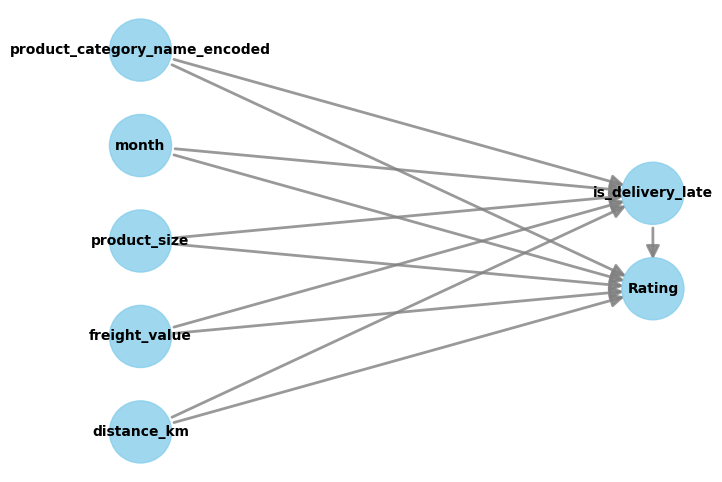

In [9]:
# Step 1: Build the causal model
# We specify the treatment, outcome, and confounders in the model.
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=covariates
)

# Step 2: View the graphical model (optional)
# This visualizes the causal structure and how variables are related.
model.view_model()

In [10]:
# Step 3: Identify the causal effect
# Specify how to estimate the causal effect. Here we use matching with propensity scores.
identified_estimand = model.identify_effect()

In [11]:
# Step 4: Estimate the treatment effect using propensity score matching
# This will estimate the causal effect using Propensity Score Matching (PSM).
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)

In [14]:
# Save the estimated effect
with open('../results/models/estimated_effect_po.pkl', 'wb') as f:
    pickle.dump(estimate, f)

In [15]:
with open('../results/models/estimated_effect_po.pkl', 'rb') as f:
    loaded_estimate = pickle.load(f)

In [18]:
loaded_estimate.interpret()

Increasing the treatment variable(s) [is_delivery_late] from 0 to 1 causes an increase of -1.9010719168241308 in the expected value of the outcome [['Rating']], over the data distribution/population represented by the dataset.


ATE (Average Treatment Effect)

In [12]:
# Step 5: View the results
# This will show the average treatment effect (ATE) of late deliveries on review scores.
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                     ↪
───────────────────(E[Rating|distance_km,freight_value,month,product_category_ ↪
d[is_delivery_late]                                                            ↪

↪                            
↪ name_encoded,product_size])
↪                            
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late} and U→Rating then P(Rating|is_delivery_late,distance_km,freight_value,month,product_category_name_encoded,product_size,U) = P(Rating|is_delivery_late,distance_km,freight_value,month,product_category_name_encoded,product_size)

## Realized estimand
b: Rating~is_delivery_late+distance_km+freight_value+month+product_category_name_encoded+product_size
Target units: ate

## Estimate
Mean value: -1.9010719168241308



Boostrap Confidence Interval

In [ ]:
# Estimate the treatment effect using Propensity Score Matching (PSM)
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)

# Display the causal estimate, confidence intervals, and standard error
print("Causal Estimate (ATE):", estimate.value)
print("Confidence Interval:", estimate.get_confidence_intervals())
print("Standard Error:", estimate.get_standard_error())

Sensitivity Analysis: Unobserved Confounder

In [ ]:
# Add an unobserved confounder and see how the treatment effect changes
refutation_unobserved_confounding = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="add_unobserved_common_cause"
)

# Display the refutation results
print(refutation_unobserved_confounding)

ATT (Average Treatment Effect on Treated)

In [ ]:
# Estimate ATT using DoWhy
estimate_ATT = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="att"  # Specify that we are interested in the ATT (treated units)
)

# Display the ATT
print("ATT (Average Treatment effect on the Treated):", estimate_ATT.value)


ATC (Average Treatment Effect on Control)

In [ ]:
# Estimate ATC using DoWhy
estimate_ATC = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="atc"  # Specify that we are interested in the ATC (control units)
)

# Display the ATC
print("ATC (Average Treatment effect on the Controls):", estimate_ATC.value)

-----